# Treasury Zero Curve Construction

This notebook constructs a zero curve from Treasury bond data using discount factor fitting with regularization.

In [1]:
%%capture
%%pip install requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize, LinearConstraint
import cvxpy as cp

EVALUATION_DATE = pd.Timestamp("2025-01-31")

## Data Loading and Preparation

In [3]:
treasury_bonds = pd.read_excel("US_Treasury_Data.xlsx", sheet_name="Bonds")
treasury_bonds['Issue Date'] = pd.to_datetime(treasury_bonds['Issue Date'])
treasury_bonds['Maturity'] = pd.to_datetime(treasury_bonds['Maturity'])
treasury_bonds.head()

,Issuer Name,Issue Date,Maturity,Bid Price,Ask Price,Cpn,Currency
0,United States Treasury Note/Bond,2018-02-28,2025-02-28,99.980469,100.007812,2.750,USD
1,United States Treasury Note/Bond,2023-02-28,2025-02-28,99.984375,100.019531,4.625,USD
2,United States Treasury Note/Bond,2020-03-02,2025-02-28,99.945312,100.011719,1.125,USD
3,United States Treasury Note/Bond,2022-03-15,2025-03-15,99.859375,99.914062,1.750,USD
4,United States Treasury Note/Bond,2020-03-31,2025-03-31,99.621094,99.703125,0.500,USD


## Time Calculation

Using the Actual/365 day count convention:

$$t = \frac{\text{Actual Days}}{365}$$

In [4]:
def calculate_time_fraction(start_date, end_date):
    return (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days / 365.0

## Payment Schedule Generation

Treasury bonds pay coupons semiannually. The payment schedule is generated by working backwards from maturity.

The payment dates are calculated using:

$$t_i = T - i \times \frac{6}{12} \text{ months, where } i = 0, 1, 2, \ldots$$

Subject to: $t_i \geq \text{Issue Date} - 31 \text{ days}$

In [5]:
def generate_payment_schedule(issue_date, maturity_date):
    payment_dates = []
    current_date = pd.Timestamp(maturity_date)
    while current_date >= pd.Timestamp(issue_date) - pd.Timedelta(days=31):
        payment_dates.append(current_date)
        current_date = current_date - pd.DateOffset(months=6)
    return sorted(payment_dates)

## Cashflow Construction

For each bond, cashflows consist of:
- Semiannual coupon payments: $C = \frac{\text{Coupon Rate} \times \text{Face Value}}{2}$
- Principal repayment at maturity: $\text{Face Value}$

In [6]:
def construct_bond_cashflows(bond_data, evaluation_date, face_value=100.0, payment_frequency=2):
    issue_date = pd.to_datetime(bond_data["Issue Date"])
    maturity_date = pd.to_datetime(bond_data["Maturity"])
    annual_coupon_rate = float(bond_data["Cpn"])
    periodic_coupon = face_value * (annual_coupon_rate / 100.0) / payment_frequency
    
    payment_schedule = generate_payment_schedule(issue_date, maturity_date)
    future_payments = [date for date in payment_schedule if date > pd.Timestamp(evaluation_date)]
    
    cashflow_list = []
    for payment_date in future_payments:
        payment_amount = periodic_coupon
        if payment_date == pd.Timestamp(maturity_date):
            payment_amount += face_value
        cashflow_list.append((payment_date, payment_amount))
    return cashflow_list

## Accrued Interest Calculation

Accrued interest for bonds trading between coupon dates:

$$\text{AI} = C \times \frac{\text{Days since last coupon}}{\text{Days in coupon period}}$$

In [7]:
def calculate_accrued_interest(bond_data, evaluation_date, payment_frequency=2, face_value=100.0):
    issue_date = pd.to_datetime(bond_data["Issue Date"])
    maturity_date = pd.to_datetime(bond_data["Maturity"])
    annual_coupon_rate = float(bond_data["Cpn"])
    periodic_coupon = face_value * (annual_coupon_rate / 100.0) / payment_frequency
    
    payment_schedule = generate_payment_schedule(issue_date, maturity_date)
    previous_coupon = max([date for date in payment_schedule if date <= pd.Timestamp(evaluation_date)], default=None)
    next_coupon = min([date for date in payment_schedule if date > pd.Timestamp(evaluation_date)], default=None)
    
    if previous_coupon is None or next_coupon is None:
        return 0.0
    
    days_accrued = (pd.Timestamp(evaluation_date) - previous_coupon).days
    days_in_period = (next_coupon - previous_coupon).days
    
    if days_in_period <= 0:
        return 0.0
    
    accrual_fraction = days_accrued / days_in_period
    return periodic_coupon * accrual_fraction

## Dirty Price Calculation

$$\text{Dirty Price} = \text{Clean Price} + \text{Accrued Interest}$$

In [8]:
def compute_dirty_prices(bond_portfolio, evaluation_date):
    dirty_price_list = []
    for _, bond_row in bond_portfolio.iterrows():
        mid_clean_price = np.nanmean([bond_row.get("Bid Price", np.nan), bond_row.get("Ask Price", np.nan)])
        if np.isnan(mid_clean_price):
            mid_clean_price = bond_row.get("Bid Price", np.nan)
        accrued_interest = calculate_accrued_interest(bond_row, evaluation_date)
        dirty_price_list.append(mid_clean_price + accrued_interest)
    return np.array(dirty_price_list)

## Discount Factor Optimization

The optimization problem minimizes:

$$\min_{D} \sum_{i=1}^{n} \left( P_i - \sum_{j} C_{ij} D_j \right)^2 + \lambda_1 \sum_{j} (D_{j+1} - 2D_j + D_{j-1})^2 + \lambda_2 \sum_{j} (D_{j+1} - D_j)^2$$

Subject to: $0 < D_j \leq 1$ and $D_j \geq D_{j+1}$ (monotonicity)



This optimization problem balances three key objectives to construct a realistic yield curve:

1. **Fit Term (Data Fidelity)**: $\sum_{i=1}^{n} \left( P_i - \sum_{j} C_{ij} D_j \right)^2$
   - $P_i$ = Market price of bond $i$
   - $C_{ij}$ = Cashflow matrix (amount of cashflow for bond $i$ at time point $j$)
   - $D_j$ = Discount factor at time point $j$
   - This term minimizes the squared difference between observed market prices and model-predicted prices

2. **Smoothness Penalty (Second Derivative)**: $\lambda_1 \sum_{j} (D_{j+1} - 2D_j + D_{j-1})^2$
   - $\lambda_1$ = Weight for the smoothness penalty
   - This term penalizes curvature in the discount factor curve
   - Approximates the second derivative of the discount factor curve
   - Prevents overfitting and ensures a smooth yield curve

3. **Ridge Regularization (First Derivative)**: $\lambda_2 \sum_{j} (D_{j+1} - D_j)^2$
   - $\lambda_2$ = Weight for the ridge penalty
   - This term penalizes large changes between adjacent discount factors
   - Helps stabilize the optimization and prevents extreme slopes

**Constraints:**
- **Bounds**: $0 < D_j \leq 1$
  - Ensures discount factors are positive and at most 1
  - Reflects the time value of money (future cashflows are worth less than present cashflows)

- **Monotonicity**: $D_j \geq D_{j+1}$
  - Ensures discount factors decrease over time
  - Guarantees non-negative forward rates
  - Prevents arbitrage opportunities in the yield curve
  - Reflects the financial principle that money today is worth more than money tomorrow

The monotonicity constraint is particularly important as it ensures the economic soundness of the yield curve. Without this constraint, the model might produce negative forward rates, which would create arbitrage opportunities in the market. The constraint enforces the fundamental financial principle that discount factors should decrease as time increases, reflecting the time value of money and ensuring that implied forward rates remain non-negative.

In [9]:
def optimize_discount_factors(bond_portfolio, evaluation_date, use_dirty_prices=True,
                             smoothness_penalty=5e4, monotonicity_penalty=5e3, ridge_penalty=1e-6):
    all_cashflow_data = []
    for _, bond_row in bond_portfolio.iterrows():
        all_cashflow_data.append(construct_bond_cashflows(bond_row, evaluation_date))
    
    unique_payment_dates = sorted({date for cashflows in all_cashflow_data for (date, _) in cashflows})
    if not unique_payment_dates:
        raise ValueError("No future cashflows after evaluation date.")
    
    num_bonds, num_dates = len(bond_portfolio), len(unique_payment_dates)
    
    cashflow_matrix = np.zeros((num_bonds, num_dates))
    for bond_index, cashflows in enumerate(all_cashflow_data):
        for payment_date, payment_amount in cashflows:
            date_index = unique_payment_dates.index(payment_date)
            cashflow_matrix[bond_index, date_index] += payment_amount

    if use_dirty_prices:
        price_vector = compute_dirty_prices(bond_portfolio, evaluation_date)
    else:
        price_vector = np.array([np.nanmean([row.get("Bid Price", np.nan), row.get("Ask Price", np.nan)]) 
                                if not np.isnan(np.nanmean([row.get("Bid Price", np.nan), row.get("Ask Price", np.nan)]))
                                else row.get("Bid Price", np.nan)
                                for _, row in bond_portfolio.iterrows()])

    d = cp.Variable(num_dates)
    fit_error = cp.sum_squares(cashflow_matrix @ d - price_vector)
    smoothness_term = 0
    if num_dates >= 3:
        smoothness_term = smoothness_penalty * cp.sum_squares(cp.diff(d, k=2))
    ridge_term = ridge_penalty * cp.sum_squares(d)
    objective = cp.Minimize(fit_error + smoothness_term + ridge_term)
    constraints = [
        d >= 1e-9,  
        d <= 1.0  
    ]
    
    if num_dates >= 2:
        constraints.append(cp.diff(d, k=1) <= 0)
    prob = cp.Problem(objective, constraints)
    prob.solve()
    discount_factors = np.clip(d.value, 1e-9, 1.0)
    
    time_to_maturity = np.array([calculate_time_fraction(evaluation_date, date) for date in unique_payment_dates])
    time_to_maturity = np.maximum(time_to_maturity, 1e-9)
    continuous_zero_rates = -np.log(discount_factors) / time_to_maturity
    
    yield_curve_data = pd.DataFrame({
        "payment_date": unique_payment_dates,
        "time_years": time_to_maturity,
        "discount_factor": discount_factors,
        "zero_rate_continuous": continuous_zero_rates
    })
    return yield_curve_data

## Zero Rate Calculation

From discount factors to continuously compounded zero rates:

$$r(t) = -\frac{\ln(D(t))}{t}$$

In [10]:
fitted_curve = optimize_discount_factors(
    treasury_bonds, EVALUATION_DATE, use_dirty_prices=True, smoothness_penalty=5e4, monotonicity_penalty=5e3
)
fitted_curve.head(10)

,payment_date,time_years,discount_factor,zero_rate_continuous
0,2025-02-15,0.041096,0.998263,0.042313
1,2025-02-28,0.076712,0.997521,0.032350
2,2025-03-15,0.117808,0.996620,0.028743
3,2025-03-30,0.158904,0.995522,0.028243
4,2025-03-31,0.161644,0.994224,0.035835
5,2025-04-15,0.202740,0.992708,0.036097
6,2025-04-30,0.243836,0.991153,0.036445
7,2025-05-15,0.284932,0.989705,0.036320
8,2025-05-30,0.326027,0.988352,0.035938
9,2025-05-31,0.328767,0.986960,0.039923


## Yield Curve Visualization

The zero curve shows the relationship between time to maturity and zero rates.

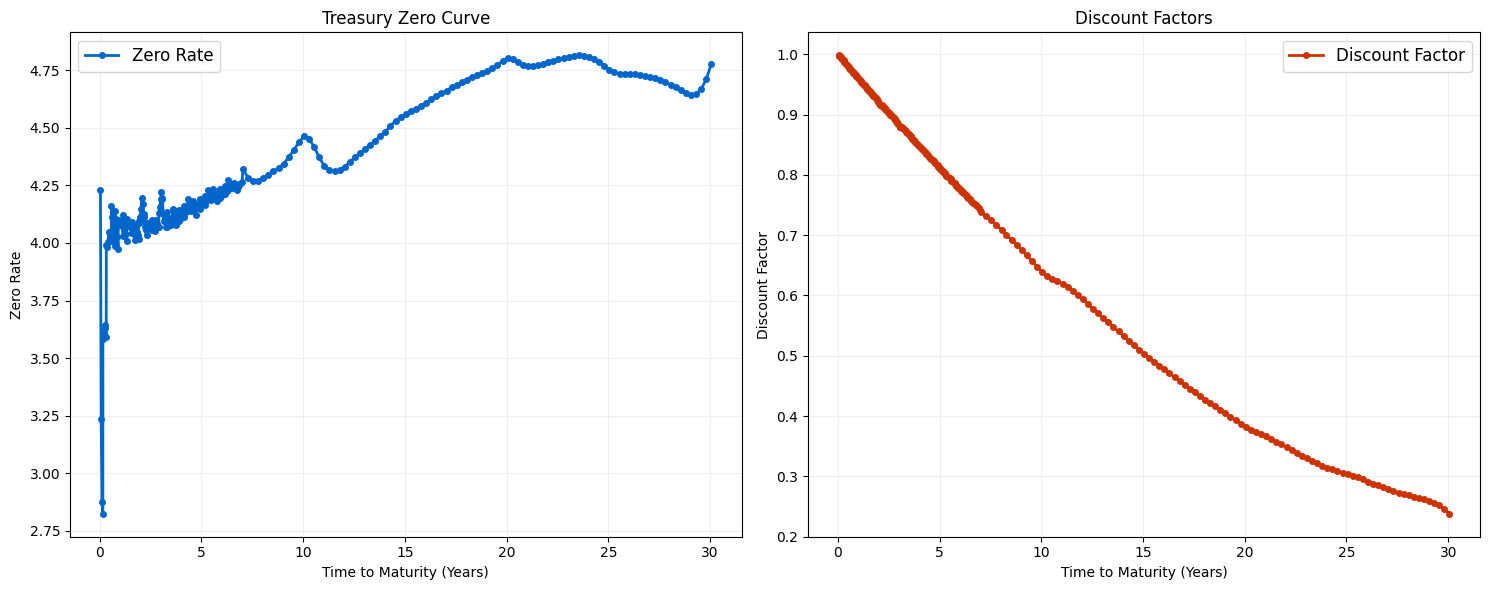

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(fitted_curve['time_years'], fitted_curve['zero_rate_continuous'] * 100, '#0066cc', linewidth=2, marker='o', markersize=4, label='Zero Rate')
ax1.set_xlabel('Time to Maturity (Years)')
ax1.set_ylabel('Zero Rate')
ax1.set_title('Treasury Zero Curve')
ax1.set_facecolor("white")
ax1.grid(True, alpha=0.3, color='#cccccc')

ax2.plot(fitted_curve['time_years'], fitted_curve['discount_factor'], '#cc3300', linewidth=2, marker='o', markersize=4, label='Discount Factor')
ax2.set_xlabel('Time to Maturity (Years)')
ax2.set_ylabel('Discount Factor')
ax2.set_title('Discount Factors')
ax2.set_facecolor("white")
ax2.grid(True, alpha=0.3, color='#cccccc')

ax1.legend(fontsize=12, frameon=True, loc="best")
ax2.legend(fontsize=12, frameon=True, loc="best")
plt.tight_layout()
plt.show()

## Model Validation

Bond pricing validation using the fitted curve:

$$P_{\text{theoretical}} = \sum_{i=1}^{n} C_i \times D(t_i)$$

In [12]:
def validate_pricing_model(bond_portfolio, yield_curve, evaluation_date):
    theoretical_prices = []
    market_prices = compute_dirty_prices(bond_portfolio, evaluation_date)
    cs = CubicSpline(yield_curve['time_years'].values, yield_curve['discount_factor'].values, bc_type='natural')
    
    for _, bond_row in bond_portfolio.iterrows():
        bond_cashflows = construct_bond_cashflows(bond_row, evaluation_date)
        theoretical_price = 0.0
        
        for payment_date, payment_amount in bond_cashflows:
            time_fraction = calculate_time_fraction(evaluation_date, payment_date)
            
            if time_fraction in yield_curve['time_years'].values:
                discount_factor = yield_curve[yield_curve['time_years'] == time_fraction]['discount_factor'].iloc[0]
            else:
                discount_factor = cs(time_fraction)
            
            theoretical_price += payment_amount * discount_factor
        
        theoretical_prices.append(theoretical_price)
    
    theoretical_prices = np.array(theoretical_prices)
    pricing_residuals = market_prices - theoretical_prices
    root_mean_square_error = np.sqrt(np.mean(pricing_residuals**2))
    mean_absolute_error = np.mean(np.abs(pricing_residuals))
    
    print(f"Model Validation Results:")
    print(f"RMSE: {root_mean_square_error:.4f}")
    print(f"MAE: {mean_absolute_error:.4f}")
    print(f"Max Absolute Error: {np.max(np.abs(pricing_residuals)):.4f}")
    
    return theoretical_prices, market_prices, pricing_residuals

predicted_prices, observed_prices, residuals = validate_pricing_model(treasury_bonds, fitted_curve, EVALUATION_DATE)

Model Validation Results:
RMSE: 0.2166
MAE: 0.1147
Max Absolute Error: 1.6783


## Pricing Accuracy Analysis

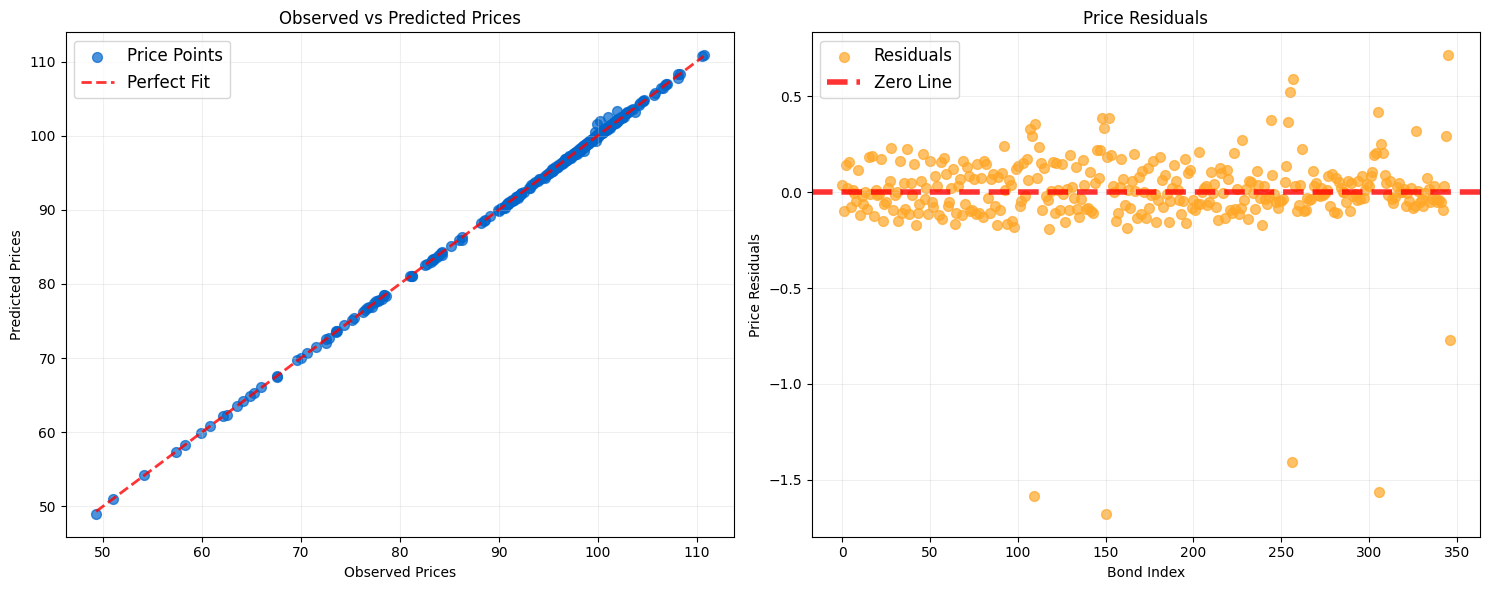

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(observed_prices, predicted_prices, alpha=0.7, color='#0066cc', s=50, label='Price Points')
ax1.plot([observed_prices.min(), observed_prices.max()], [observed_prices.min(), observed_prices.max()], 'red', linestyle='--', alpha=0.8, linewidth=2, label='Perfect Fit')
ax1.set_xlabel('Observed Prices')
ax1.set_ylabel('Predicted Prices')
ax1.set_title('Observed vs Predicted Prices')
ax1.legend(loc='lower left', fontsize=10, frameon=True)
ax1.grid(True, alpha=0.3, color='#cccccc')

ax2.scatter(range(len(residuals)), residuals, alpha=0.7, color='#ffa726', s=50, label='Residuals')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=4, label='Zero Line')
ax2.set_xlabel('Bond Index')
ax2.set_ylabel('Price Residuals')
ax2.set_title('Price Residuals')
ax2.legend(loc='lower left', fontsize=10, frameon=True)
ax2.grid(True, alpha=0.3, color='#cccccc')

ax1.legend(fontsize=12, frameon=True, loc="best")
ax2.legend(fontsize=12, frameon=True, loc="best")
plt.tight_layout()
plt.show()

## Results Export

In [ ]:
final_results = treasury_bonds.copy()
final_results['Observed_Price'] = observed_prices
final_results['Predicted_Price'] = predicted_prices
final_results['Price_Residual'] = residuals

fitted_curve.to_csv('data/processed/treasury_zero_curve.csv', index=False)
final_results.to_csv('data/processed/bond_pricing_results.csv', index=False)


print("=== FITTED ZERO CURVE ===")
print(fitted_curve.head(10))

print("\n=== BOND PRICING RESULTS ===")
print(final_results.head(10))


=== FITTED ZERO CURVE ===
  payment_date  time_years  discount_factor  zero_rate_continuous
0   2025-02-15    0.041096         0.998263              0.042313
1   2025-02-28    0.076712         0.997521              0.032350
2   2025-03-15    0.117808         0.996620              0.028743
3   2025-03-30    0.158904         0.995522              0.028243
4   2025-03-31    0.161644         0.994224              0.035835
5   2025-04-15    0.202740         0.992708              0.036097
6   2025-04-30    0.243836         0.991153              0.036445
7   2025-05-15    0.284932         0.989705              0.036320
8   2025-05-30    0.326027         0.988352              0.035938
9   2025-05-31    0.328767         0.986960              0.039923



=== BOND PRICING RESULTS ===
                        Issuer Name Issue Date   Maturity  Bid Price  \
0  United States Treasury Note/Bond 2018-02-28 2025-02-28  99.980469   
1  United States Treasury Note/Bond 2023-02-28 2025-02-28  99.984375   
